In [1]:
import os
import glob
import csv
from collections import Counter, defaultdict
import pandas as pd
import numpy as np

import omop_analyze
import s4s_analyze

original_path = os.getcwd()

def omop_formatted(tables):
    return {filename: len(table) for filename, table in tables.items()}
    
def s4s_formatted(counts):
    return {k: len(v) for k, v in counts.items()}

def filter_matches(omop_tables, s4s_uniques):
    return filter_procedures(omop_tables, s4s_uniques)

def filter_procedures(omop_tables, s4s_uniques):
    return omop_tables, s4s_uniques

def csv_to_dicts(filename):
    with open(filename, encoding="utf8") as csv_file:
        items = (filename, list(csv.DictReader(csv_file, delimiter="\t")))
    return items

vocab = csv_to_dicts('VOCABULARY.csv')[1]
vocab_df = pd.DataFrame(vocab)
concept = csv_to_dicts('CONCEPT.csv')[1]
concept_df = pd.DataFrame(concept)

In [2]:
omop_dump = omop_analyze.data_dump()
# combine observation_1 and observation_2
# tables['observation.csv'] = 
omop_tables = {}
for key, value in dict(omop_dump).items():
    if key == 'observation_1.csv':
        omop_tables['observation.csv'] = value[1]
    elif key == 'observation_2.csv':
        if 'observation.csv' in omop_tables:
            omop_tables['observation.csv'] += value[1]
        else:
            omop_tables['observation.csv'] = value[1]
    else:
        omop_tables[key] = value[1]
omop_tables.keys()

['condition.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']


dict_keys(['condition.csv', 'observation.csv', 'procedure.csv'])

In [3]:
omop_data_types = ['condition', 'observation', 'procedure']
omop_people = omop_analyze.parse_omop()
#combine observation_1 and observation_2
for person, data_types in omop_people.items():
    if 'observation_1.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_1.csv']
        del data_types['observation_1.csv']
        if 'observation_2.csv' in data_types.keys():
            data_types['observation.csv'].append(data_types['observation_2.csv'])
            del data_types['observation_2.csv']
    elif 'observation_2.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_2.csv']
        del data_types['observation_2.csv']
print("Got {} omop participants".format(len(omop_people.keys())))

['condition.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']
Got 72 omop participants


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000001D2AEA438>],
      dtype=object)

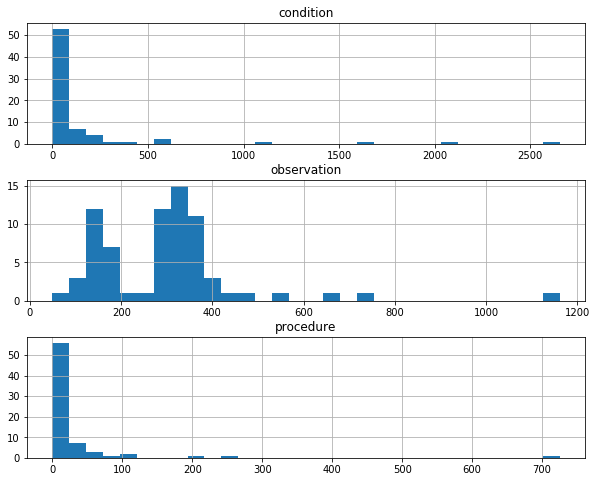

In [9]:
# Histogram showing counts for each OMOP data type, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)
omop_data_types_per_person = {data_type: [len(person[data_type+'.csv']) if data_type+'.csv' in person.keys() else 0 for person in omop_people.values()] for data_type in omop_data_types}
omop_df_types = pd.DataFrame(omop_data_types_per_person, index=omop_people.values())
omop_df_types.hist(bins=30, figsize=(10,8), layout=(3,1))

In [5]:
# Count of standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_concept_id.
vocabulary_sources = Counter()
for person, tables in omop_people.items():
    for filename, incidents in tables.items():
        for incident in incidents:
            vocabulary_sources[filename + '-' + incident['source_vocabulary']] += 1
vocabulary_sources

Counter({'condition.csv-ICD10CM': 7212,
         'condition.csv-ICD9CM': 4051,
         'procedure.csv-CPT4': 1287,
         'observation.csv-PPI': 9013,
         'observation.csv-None': 12106,
         'procedure.csv-ICD10CM': 186,
         'procedure.csv-ICD10PCS': 202,
         'procedure.csv-ICD9CM': 225,
         'observation.csv-ICD10CM': 147,
         'procedure.csv-ICD9Proc': 97,
         'observation.csv-ICD9CM': 206,
         'procedure.csv-HCPCS': 23})

In [6]:
# Count of non-standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_source_concept_id

In [7]:
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?


In [8]:
# For each OMOP column, how often was a value present vs absent?
procedure_df = pd.DataFrame(omop_tables['procedure.csv'])
print("Number of rows: ", len(procedure_df))
procedure_columns = set(procedure_df.columns) - {
    'person_id',
    'procedure_date',
    'procedure_datetime',
    'procedure_occurrence_id'
}
for column in procedure_columns:
    print(procedure_df[column].value_counts()[:3])

Number of rows:  2020
1    1582
      438
Name: quantity, dtype: int64
            1439
0            438
42739576      53
Name: modifier_concept_id, dtype: int64
cpmc_ceders    1582
nec_phs         438
Name: src_hpo_id, dtype: int64
0           1337
44786630     683
Name: procedure_type_concept_id, dtype: int64
2108115    154
2414398     85
2414397     69
Name: procedure_concept_id, dtype: int64
         272
36415    154
99214     85
Name: procedure_source_value, dtype: int64
4000000000181312    10
4000000000169699     9
4000000000178509     9
Name: visit_occurrence_id, dtype: int64
2108115    154
2414398     85
2414397     69
Name: procedure_source_concept_id, dtype: int64
CPT4        1287
ICD9CM       225
ICD10PCS     202
Name: source_vocabulary, dtype: int64
36415    154
99214     85
99213     69
Name: source_code_structured, dtype: int64
    2020
Name: qualifier_source_value, dtype: int64
0    1582
      438
Name: provider_id, dtype: int64


In [11]:
concept_df['domain_id'].value_counts()

Drug                   3581327
Condition               281240
Device                  205906
Geography               203352
Observation             202896
Measurement             131162
Procedure                84999
Spec Anatomic Site       34291
Meas Value               16779
Metadata                  3133
Unit                      2349
Type Concept              2106
Specimen                  1817
Provider                  1370
Visit                      640
Revenue Code               538
Place of Service           397
Race                       364
Relationship               198
Route                      196
Currency                   180
Payer                      162
Condition/Meas             111
Cost                        51
Meas/Procedure              22
Condition/Procedure         19
Gender                      16
Plan Stop Reason            13
Plan                        11
Sponsor                      6
Episode                      6
Meas Value Operator          5
Spec Dis

In [17]:
concept_df.loc[concept_df['concept_id'] == 2108115]
# Unsure why no rows show up, it's the most common procedure_concept_id?

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason


In [13]:
observation_df = pd.DataFrame(omop_tables['observation.csv'])
print("Number of rows: ", len(observation_df))
observation_columns = set(observation_df.columns) - {
    'observation_id',
    'person_id',
    'observation_date',
    'observation_datetime',
}
observation_columns
for column in observation_columns:
    print(observation_df[column].value_counts()[:3])

Number of rows:  21472
0           9807
903096      3758
45878245     639
Name: value_as_concept_id, dtype: int64
0         9999
903096    3758
          3007
Name: value_source_concept_id, dtype: int64
    21472
Name: unit_source_value, dtype: int64
bp_systolic     325
bp_diastolic    325
weight          317
Name: observation_source_value, dtype: int64
rdr            18465
cpmc_ceders     2654
nec_phs          353
Name: src_hpo_id, dtype: int64
0          9455
4041306    2654
1586155     139
Name: observation_concept_id, dtype: int64
None      12106
PPI        9013
ICD9CM      206
Name: source_vocabulary, dtype: int64
0          12106
1586155      139
1585636      129
Name: observation_source_concept_id, dtype: int64
No matching concept                   12106
White_WhiteSpecific                     139
RecreationalDrugUse_WhichDrugsUsed      129
Name: source_code_structured, dtype: int64
     21119
0      353
Name: provider_id, dtype: int64
0    18465
      3007
Name: qualifier_conce

In [14]:
# For each OMOP column, how often was a value present vs absent?
condition_df = pd.DataFrame(omop_tables['condition.csv'])
print("Number of rows: ", len(condition_df))
condition_columns = set(condition_df.columns) - {
    'person_id',
    'condition_start_date',
    'condition_start_datetime',
    'condition_end_date',
    'condition_end_datetime',
    'condition_occurrence_id'
}
for column in condition_columns:
    print(condition_df[column].value_counts()[:3])

Number of rows:  11263
    11263
Name: stop_reason, dtype: int64
cpmc_ceders    6545
nec_phs        4718
Name: src_hpo_id, dtype: int64
      10898
AD      365
Name: condition_status_source_value, dtype: int64
0           4514
44786629    4284
44786627    2465
Name: condition_type_concept_id, dtype: int64
137809     872
4157332    506
0          495
Name: condition_concept_id, dtype: int64
4000000000023113    45
4000000000030830    43
4000000000027144    43
Name: visit_occurrence_id, dtype: int64
0           6180
4203942      365
44821787     144
Name: condition_status_concept_id, dtype: int64
45556996    610
45552285    404
45600511    396
Name: condition_source_concept_id, dtype: int64
ICD10CM    7212
ICD9CM     4051
Name: source_vocabulary, dtype: int64
C50.912    610
C79.51     404
C50.919    396
Name: source_code_structured, dtype: int64
C50.912    610
C79.51     404
C50.919    396
Name: condition_source_value, dtype: int64
0    6545
     4718
Name: provider_id, dtype: int64


In [ ]:
s4s_people_stats = {}
total_counts = defaultdict(lambda: defaultdict(list))      
search_path = os.path.join(original_path, 'fhir', 'Participant', '*', 'SyncForScience')
for directory in glob.glob(search_path):
    base_uri, dir_counts = s4s_analyze.process_directory(directory)
    person_id = directory.split('\\')[-2][1:]
    s4s_people_stats[person_id] = dir_counts
print("got {} s4s participants".format(len(s4s_people_stats.keys())))

In [ ]:
# for person, tables in omop_people_stats.items():
#     # print("OMOP: {}\nMatching S4S: {}\n".format(omop_formatted(tables), s4s_formatted(s4s_people_stats[person])))
#     print("Patient: {}\n{}\n".format(person, filter_procedures(tables, s4s_people_stats[person])))

In [ ]:
s4s_df = pd.DataFrame(s4s_people_stats)
s4s_df

In [ ]:
##### S4S Data #####
# Histogram showing counts for each data category, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)
# Count of code *systems* for each data category. E.g., fraction of SNOMED vs LOINC vs Other codes found in Conditions.
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?
# Count of valid vs invalid codes for each data category. E.g. how many valid Condition codes, how many invalid, and how many missing?
# Distribution of number of Codings present in CodeableConcepts for each data category. I.e., how often were translation codes supplied for Conditions?
# Complete "tree" of FHIR paths for each data category. E.g., for Condition, which JSON elements (and sub elements, and so on, recursively) are present?
# Same "tree" of FHIR paths as above, with each node annotated by count. E.g., for Condition.code.coding[0].system, how many times was this path present?
# For each status flag, what is the distribution of values? E.g., for Condition.clinicalStatus, how often is the value active | relapse | remission | resolved?


In [ ]:
##### Comparing OMOP to S4S #####
# Draw a distribution of "total # data elements in OMOP vs S4S" for each data category. E;g., each patient would contribute one dot to a Condition Count histogram by taking (# S4S Conditions - # OMOP conditions), which will be a positive number if more S4S conditions, and a negative number of more OMOP conditions.
# TODO (how to specify): show which values appeared in S4S but not OMOP, and vice versa.
# TODO: after early exploration, what else do we want to evaluate?
